# This code creates the Final Data from Raw Data 

In [25]:
import pandas as pd
import quandl
import numpy as np
import quandl
import matplotlib.pyplot as plt
import os
import math
import talib
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from sklearn.metrics import accuracy_score
import seaborn as sns
import operator
import warnings
warnings.filterwarnings("ignore")

plt.rc('figure', figsize=(20, 8), dpi=100)
from datetime import datetime
path = os.getcwd()
print (path)
#path = path + "/Desktop/ProjectData/"
#os.chdir(path)

/Users/abhishekmukherjee/Desktop/ProjectData/BNYMellon


In [96]:
#Change the name of the stock according to the folder
stock = "BNYMellon"

os.chdir("/Users/abhishekmukherjee/Desktop/ProjectData/" + stock)

### Process Technical Data

In [97]:
class MovingAverages:
    
    def _init_(self):
        pass
    def SMA(self, data, factor, days):
    
        data["SMA_"+ str(days) + "_" + factor] = talib.SMA(data[factor], timeperiod=days)
        return data
    
    def EMA(self, data, factor, days):
    
        data["EMA_"+ str(days) + "_" + factor] = talib.EMA(data[factor], timeperiod=days)
        return data
    
    def DEMA(self, data, factor, days):
    
        data["DEMA_"+ str(days) + "_" + factor] = talib.DEMA(data[factor], timeperiod=days)
        return data
    
    def HT(self, data, factor):
    
        data["HT_" + factor] = talib.HT_TRENDLINE(data[factor])
        return data
    
    def KAMA(self, data, factor, days):
    
        data["KAMA_"+ str(days) + "_" + factor] = talib.KAMA(data[factor], timeperiod=days)
        return data
    
    def MAMA(self, data, factor):
    
        mama, fama = talib.MAMA(data[factor], fastlimit=0.8, slowlimit=0.2)
        data["MAMA_" + factor] = mama
        data["FAMA_" + factor] = fama
        return data
    
    def TEMA(self, data, factor, days):
    
        data["TEMA_"+ str(days) + "_" + factor] = talib.TEMA(data[factor], timeperiod=days)
        return data
    
    def TRIMA(self, data, factor, days):
    
        data["TRIMA_"+ str(days) + "_" + factor] = talib.TRIMA(data[factor], timeperiod=days)
        return data
    
    def WMA(self, data, factor, days):
    
        data["WMA_"+ str(days) + "_" + factor] = talib.WMA(data[factor], timeperiod=days)
        return data

In [98]:
class IndicatorsAndTransforms:
    
    def technicalIndicators(self, df):
    
        #Compute Daily Return
        data = df.copy()
        data['Daily_Return'] = (data['Close'] - data['Open'])/data['Open']

        time_periods = [14, 26, 52, 128, 252]
        factors = ['Close', 'Daily_Return', 'Volume']

        #Compute various types of Time and factor varying Moving Averages
        mv = MovingAverages()
        
        for days in time_periods:
            for factor in factors: 
                data = mv.SMA(data, factor, days)
                data = mv.EMA(data, factor, days)
                data = mv.DEMA(data, factor, days)
                data = mv.KAMA(data, factor, days)
                data = mv.TEMA(data, factor, days)
                data = mv.TRIMA(data, factor, days)
                data = mv.WMA(data, factor, days)

        #Compute the Hilbert Transform and Mesa Adaptive Moving Average
        for factor in factors: 
            data = mv.HT(data, factor)
            #data = MAMA(data, factor)

        close, open_, high, low, volume = data['Close'], data['Open'], data['High'], data['Low'], data['Volume']

        #Compute Parabolic SAR
        data['SAR'] = talib.SAR(high, low, acceleration=0.7, maximum=0.2)

        #Compute various Momentum based Indicators

        data['ADX_14'] = talib.ADX(high, low, close, timeperiod= 14)
        data['ADXR_14'] = talib.ADXR(high, low, close, timeperiod= 14)
        data['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
        data['aroondown_14'], data['aroonup_14'] = talib.AROON(high, low, timeperiod=14)
        data['AROONOSC_14'] = talib.AROONOSC(high, low, timeperiod=14)
        data['BOP_14'] = talib.BOP(open_, high, low, close)
        data['CCI_14'] = talib.CCI(high, low, close, timeperiod=14)
        data['CMO_14'] = talib.CMO(close, timeperiod=14)
        data['DX_14'] = talib.DX(high, low, close, timeperiod=14)
        data['macd'], data['macdsignal'], data['macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
        data['MFI_14'] = talib.MFI(high, low, close, volume, timeperiod=14)    
        data['MINUS_DM_14'] = talib.MINUS_DM(high, low, timeperiod=14)
        data['MOM_10'] = talib.MOM(close, timeperiod=10)
        data['PLUS_DI_14'] = talib.PLUS_DI(high, low, close, timeperiod=14)
        data['PLUS_DM_14'] = talib.PLUS_DM(high, low, timeperiod=14)
        data['PPO'] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
        data['ROC_10'] = talib.ROC(close, timeperiod=10)
        data['ROCP_10'] = talib.ROCP(close, timeperiod=10)
        data['ROCR'] = talib.ROCR(close, timeperiod=10)
        data['ROCR'] = talib.ROCR100(close, timeperiod=10)
        data['RSI_14'] = talib.RSI(close, timeperiod=14)
        data['RSI_26'] = talib.RSI(close, timeperiod=26)
        data['STOCH_slowk'], data['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
        data['STOCH_fastk'], data['STOCH_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
        data['STOCHRSI_fastk'], data['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
        data['TRIX_30'] = talib.TRIX(close, timeperiod=30)
        data['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
        data['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)


        #Volality Indicator Functions
        data['ATR_14'] = talib.ATR(high, low, close, timeperiod=14)
        data['NATR_14'] = talib.NATR(high, low, close, timeperiod=14)
        data['TRANGE'] = talib.TRANGE(high, low, close)

        #Volume Indicator Functions
        data['AD'] = talib.AD(high, low, close, volume)
        data['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
        data['OBV'] = talib.OBV(close, volume)

        #Moving Average Convergence Divergence
        data['ema26_close'] = data['Close'].ewm(span = 26).mean()
        data['ema12_close'] = data['Close'].ewm(span = 12).mean()
        data['MACD'] = (data['ema12_close']-data['ema26_close'])

        #Bollinger Bands
        data['sd_Close_26'] = data['Close'].rolling(26).std()
        data['upper_band_26'] = data['SMA_26_Close'] + (data['sd_Close_26']*2)
        data['lower_band_26'] = data['SMA_26_Close'] - (data['sd_Close_26']*2)

        #Exponential Moving Average
        data['ema_close'] = data['Close'].ewm(com=0.4).mean()

        # Create Momentum
        data['momentum'] = data['Close']-1
        try:
            data['log_momentum'] = np.log(data['momentum'])
        except:
            pass
        
        return data

In [99]:
class ProcessData:
    def _init_(self):
        pass
    def technicalData(self, data):

        df = data.copy()
        df.columns = df.iloc[1]
        df = df[3:]
        df = df.set_index('Date')
        df = df.rename(columns={"Price": "Close"})
        df = df.rename(columns={"CVol": "Volume"})
        return df

In [100]:
def fourrierTransform(df):
    
    data = df.copy()
    data_FT = data[['Date', 'Close']]
    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
    plt.figure(figsize=(14, 7), dpi=100)
    fft_list = np.asarray(fft_df['fft'].tolist())
    for num_ in [7, 10, 14, 21, 50, 40, 100]:
        fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
        #plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
        data['Close_FFT_' + str(num_)] = abs(np.fft.ifft(fft_list_m10))
    return data

In [101]:
data = pd.read_excel("Price.xlsx")
p = ProcessData()
df = p.technicalData(data)

In [102]:
t = IndicatorsAndTransforms()
df1 = df.copy()
df1 = df1[::-1]
df1 = t.technicalIndicators(df1)

In [103]:
df1 = df1.fillna(method = 'bfill')
df_tech = df1.copy()

### Process Fundamental Data

In [104]:
def date_time_parser(data):
    
    for i in range(len(data)):
        str_ = data[i]
        str_ = str_.strip()
        str_ = str_.split('\'')
        #print (str_)
        
        
        if (int(str_[1]) >= 70):
            str_[1] = "19" + str_[1]
        else:
            str_[1] = "20" + str_[1]

        str_[0] = str_[0].strip()

        if (str_[0] == 'JAN'):
            str_[0] = "01"
        elif(str_[0] == 'FEB'):
            str_[0] = "02"
        elif(str_[0] == 'MAR'):
            str_[0] = "03"
        elif(str_[0] == 'APR'):
            str_[0] = "04"
        elif(str_[0] == 'MAY'):
            str_[0] = "05"
        elif(str_[0] == 'JUN'):
            str_[0] = "06"
        elif(str_[0] == 'JUL'):
            str_[0] = "07"
        elif(str_[0] == 'AUG'):
            str_[0] = "08"
        elif(str_[0] == 'SEP'):
            str_[0] = "09"
        elif(str_[0] == 'OCT'):
            str_[0] = "10"
        elif(str_[0] == 'NOV'):
            str_[0] = "11"
        elif(str_[0] == 'DEC'):
            str_[0] = "12"

        s = str_[1] + "-" + str_[0] + "-10"
        data[i] = s
    
    return data

In [105]:
def data_cleaning(data):
    
    #Convert datatypes from object/string to float and fill missing values with previous values
    for col in data.columns:
        #print (col)
        data[col] = pd.to_numeric(data[col], errors='coerce')
        #data[col] = data[col].fillna(method = "pad")
        data[col] = data[col].fillna(method = 'ffill')

    return data

In [106]:
def processFundamentalData(data):
    
    df = data.copy()
    df['Date'] = date_time_parser(df['Date'])
    date_pd = df['Date']
    df = df.set_index(['Date'])
    df.index = pd.to_datetime(df.index)
    df = data_cleaning(df)
    df = df.resample("D").asfreq().ffill()
    return df

In [107]:
class FundamentalDataset:
    def _init_(self):
        pass
    
    def incomeStatement(self, data):
        df_income = data.copy()
        
        try:
            del df_income['EPS (recurring)']
            del df_income['EPS (diluted)']
        except:
            pass
        df_income = processFundamentalData(df_income)
        
        return df_income
    
    def otherData(self, data):
        
        df_other = data.copy()
        df_other = processFundamentalData(df_other)
        
        return df_other
    

# Main Code for Dataset Creation

In [108]:
fund = FundamentalDataset()
data_income = pd.read_excel("Income.xlsx")
data_bs = pd.read_excel("BS.xlsx")
data_cf = pd.read_excel("CF.xlsx")
data_ratio = pd.read_excel("Ratio.xlsx")
data_estimate = pd.read_excel("eps_estimate.xlsx")


In [109]:
#Converts Quarterly datasets to daily datasets
df_income = fund.incomeStatement(data_income)
df_bs = fund.otherData(data_bs)
df_cf= fund.otherData(data_cf)
df_ratio = fund.otherData(data_ratio)
df_estimate = fund.otherData(data_estimate)

In [110]:
#Merge all the datasets into a single dataset
df_t1 = pd.merge(df_tech, df_income, how='inner', on='Date')
df_t2 = pd.merge(df_t1, df_bs, how='inner', on='Date')
df_t3 = pd.merge(df_t2, df_cf, how='inner', on='Date')
df_t4 = pd.merge(df_t3, df_ratio, how='inner', on='Date')
df_t5 = pd.merge(df_t4, df_estimate, how='inner', on='Date')

In [111]:
df_t5.shape
df_t5

,Close,Volume,Change,% Change,% Return,Total Return (Gross),Cumulative Return %,Open,High,Low,...,Invested Assets+Loans/Deposits (%),Loan Losses Provision/Total Loans,Loan Losses Reserves/Total Loans,Non-Performing Loans/Total Loans,Non-Performing Loans/Loan Loss Reserves,Tier 1 Risk Based Capital Ratio (%),Total Capital Adequacy Ratio (%),Risk Weighted Assets,EPS_Analyst,Growth (YoY%)
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-10,43.989998,3713019.00,4.173752,10.482535,10.482537,142.477020,7990.827917,42.664997,43.989998,41.538746,...,116.229305,-0.025797,1.503973,0.495305,52.245509,7.44,11.49,65378.0,2.1518,7.97872
1999-12-13,42.996246,1466415.20,-0.993752,-2.259041,-2.259045,139.258400,7808.052473,43.327500,43.460000,42.731247,...,116.229305,-0.025797,1.503973,0.495305,52.245509,7.44,11.49,65378.0,2.1518,7.97872
1999-12-14,42.532497,2394151.00,-0.463749,-1.078580,-1.078570,137.756400,7722.758553,42.598747,42.996246,42.068750,...,116.229305,-0.025797,1.503973,0.495305,52.245509,7.44,11.49,65378.0,2.1518,7.97872
1999-12-15,42.002500,2258019.00,-0.529997,-1.246099,-1.246105,136.039810,7625.278733,42.598747,43.393750,41.936250,...,116.229305,-0.025797,1.503973,0.495305,52.245509,7.44,11.49,65378.0,2.1518,7.97872
1999-12-16,41.472496,2425188.70,-0.530004,-1.261839,-1.261837,134.323210,7527.798345,42.532497,42.929996,40.677498,...,116.229305,-0.025797,1.503973,0.495305,52.245509,7.44,11.49,65378.0,2.1518,7.97872
1999-12-17,41.605000,2499056.60,0.132504,0.319498,0.319498,134.752370,7552.169010,40.809998,42.201250,40.809998,...,116.229305,-0.025797,1.503973,0.495305,52.245509,7.44,11.49,65378.0,2.1518,7.97872
1999-12-20,41.538746,1284622.80,-0.066254,-0.159245,-0.159248,134.537780,7539.983109,41.472496,42.267498,41.207497,...,116.229305,-0.025797,1.503973,0.495305,52.245509,7.44,11.49,65378.0,2.1518,7.97872
1999-12-21,41.207497,1631792.50,-0.331249,-0.797446,-0.797441,133.464920,7479.058719,41.339996,42.532497,41.207497,...,116.229305,-0.025797,1.503973,0.495305,52.245509,7.44,11.49,65378.0,2.1518,7.97872
1999-12-22,41.008747,990943.40,-0.198750,-0.482315,-0.482314,132.821200,7442.503857,41.339996,41.472496,40.942497,...,116.229305,-0.025797,1.503973,0.495305,52.245509,7.44,11.49,65378.0,2.1518,7.97872


In [112]:
df_t5.to_excel(stock + "_Final.xlsx")

In [113]:
df = pd.read_excel(stock + "_Final.xlsx")
df = fourrierTransform(df)
df.to_excel(stock + "_Final.xlsx")

<Figure size 1400x700 with 0 Axes>

# Visualize Final Data

### You can add more plots to visualize other indicators, its customizable

In [124]:
class Plot:
    
    def __init__(self, dataset, last_days):
        
        self.dataset = dataset
        self.last_days = last_days
        
        plt.rc('figure', figsize=(15, 8), dpi=100)
        shape_0 = dataset.shape[0]
        xmacd_ = shape_0-last_days

        dataset = dataset.iloc[-last_days:, :]
        x_ = range(3, dataset.shape[0])
        x_ =list(dataset.index)
        self.x_ = x_
        self.dataset = dataset
        self.last_days = last_days
        self.xmacd_ = xmacd_
        self.shape_0 = shape_0
        
    def plotMovingAverageIndicators(self):
        
        last_days = self.last_days
        dataset = self.dataset
        x_ = self.x_
        #Moving Average Indicator Plots
        plt.title("Moving Average indicators of " + stock + " for last " + str(last_days) + " days")
        plt.plot(dataset['TRIMA_14_Close'],label='TRIMA_26', linestyle='--')
        plt.plot(dataset['TRIMA_26_Close'],label='TRIMA_26', linestyle='--')
        plt.plot(dataset['SMA_52_Close'],label='SMA_52', linestyle='--')
        plt.plot(dataset['SMA_26_Close'],label='SMA_26', linestyle='--')
        #plt.plot(dataset['EMA_7_Close'],label='EMA_7', linestyle='--')
        #plt.plot(dataset['EMA_14_Close'],label='EMA_14', linestyle='--')
        plt.plot(dataset['upper_band_26'],label='Upper Band', color = 'c')
        plt.plot(dataset['lower_band_26'],label='Lower Band', color = 'c')
        plt.fill_between(x_, dataset['lower_band_26'], dataset['upper_band_26'], alpha=0.05)
        plt.plot(dataset['Close'],label='Close Price')
        plt.ylabel('USD')
        plt.legend()
        plt.show()
        
    def plotMomentumIndicators(self):
        
        last_days = self.last_days
        dataset = self.dataset
        #Momentum Indicator Plots
        plt.title("Momentum indicators of " + stock +" for last " + str(last_days) + " days")
        plt.plot(dataset['ADX_14'],label='ADX_14',linestyle='--')
        plt.plot(dataset['RSI_14'],label='RSI_14', linestyle='--')
        plt.plot(dataset['MFI_14'],label='MFI_14', linestyle='--')
        plt.plot(dataset['macdsignal'],label='macdsignal', linestyle='--')
        plt.plot(dataset['ULTOSC'],label='ULTOSC', linestyle='--')
        plt.plot(dataset['WILLR'],label='WILLR', linestyle='--')
        plt.legend()
        plt.show()
    
    def plotVolatilityIndicators(self):
        
        last_days = self.last_days
        dataset = self.dataset
        #Volatility Indicator Plots
        plt.title("Volatility indicators of " + stock +" for last " + str(last_days) + " days")
        plt.plot(dataset['ATR_14'],label='ATR_14',linestyle='--')
        plt.plot(dataset['NATR_14'],label='NATR_14', linestyle='--')
        plt.plot(dataset['TRANGE'],label='TRANGE', linestyle='--')
        plt.legend()
        plt.show()
    
    def plotVolumeAndMACDIndicators(self):
        
        
        xmacd_ = self.xmacd_
        shape_0 = self.shape_0
        last_days = self.last_days
        dataset = self.dataset
        #MACD Plot
        plt.title("MACD indicators of " + stock +" for last " + str(last_days) + " days")
        plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
        plt.hlines(15, xmacd_, shape_0, colors='r', linestyles='--')
        plt.hlines(-15, xmacd_, shape_0, colors='r', linestyles='--')
        try:
            plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')
        except:
            pass
        #Volume Indicator Plots
        plt.title("Volume indicators of " + stock +" for last " + str(last_days) + " days")
        plt.plot(dataset['AD'],label='AD',linestyle='--')
        plt.plot(dataset['ADOSC'],label='ADOSC', linestyle='--')
        plt.plot(dataset['OBV'],label='OBV', linestyle='--')
        plt.legend()
        plt.show()
    



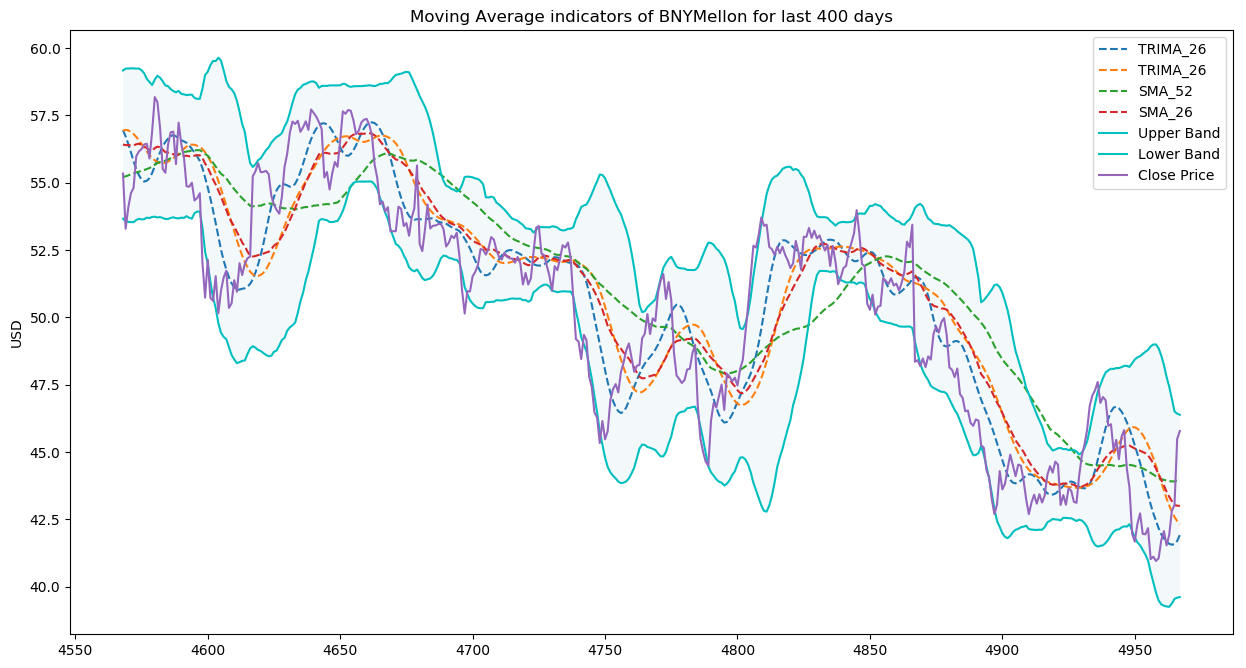

In [125]:
plot = Plot(df, 400)
plot.plotMovingAverageIndicators()

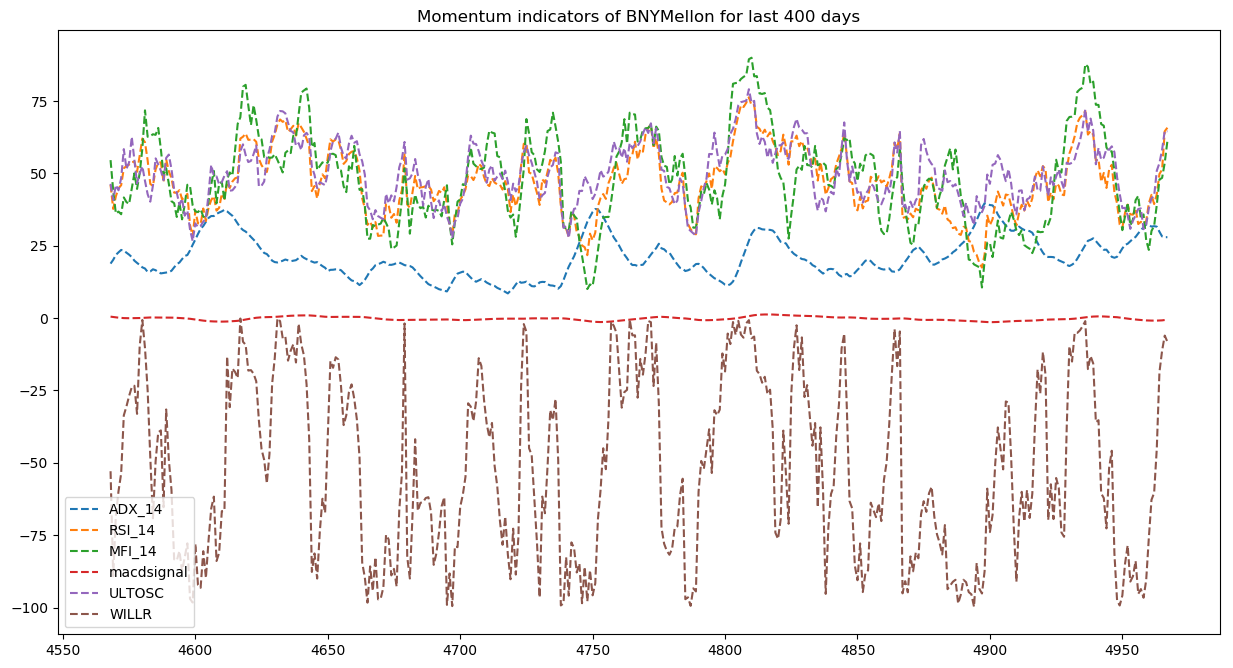

In [126]:
plot.plotMomentumIndicators()

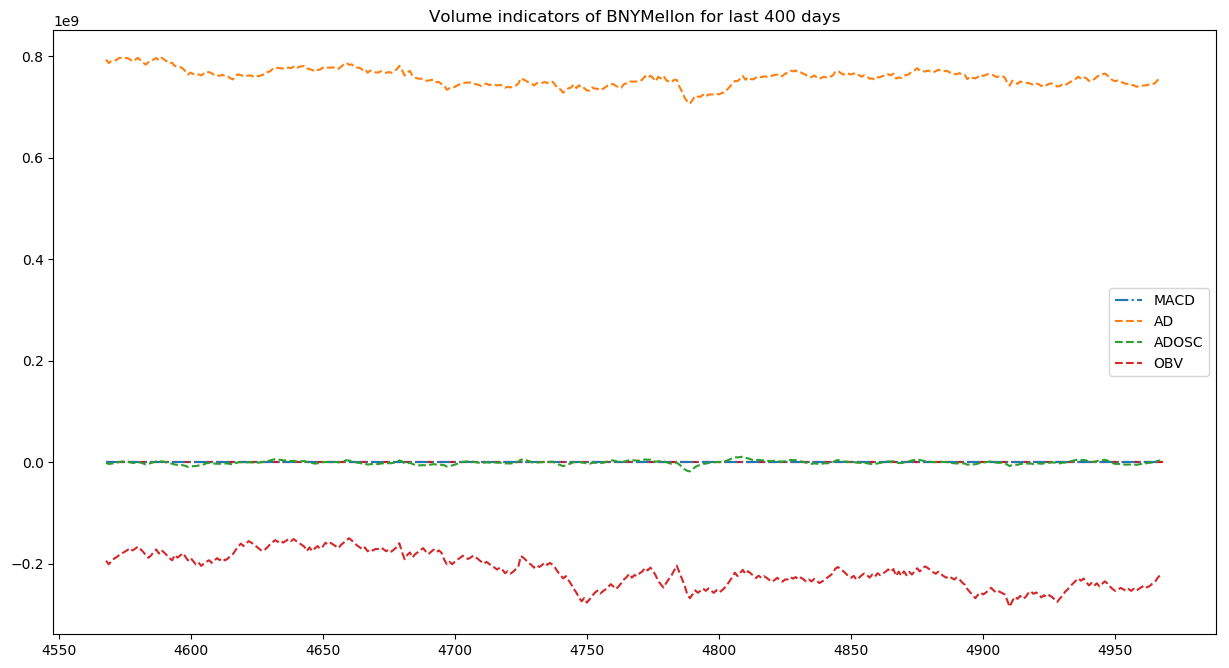

In [127]:
plot.plotVolumeAndMACDIndicators()

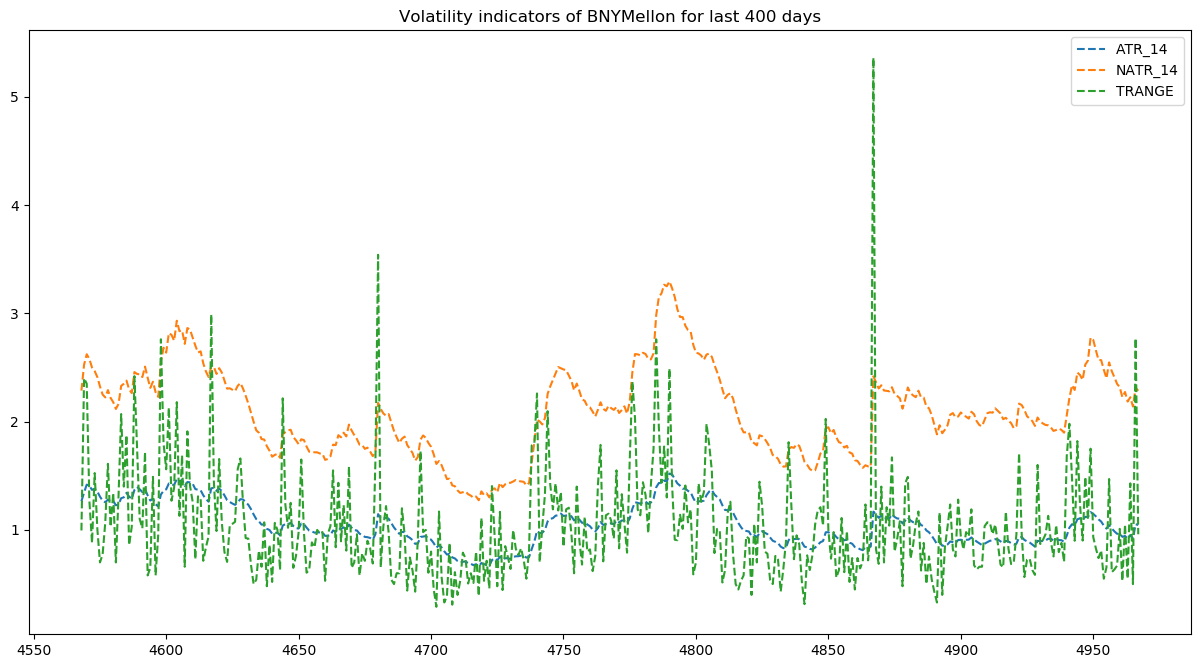

In [129]:
plot.plotVolatilityIndicators()